# ANALYSING CACI ACORN DATA

Acorn is a consumer classification dataset that segments the UK population. By analysing demographic data, 
social factors, population and consumer behaviour, it provides information and an understanding of different types 
of people.

In [2]:
#importing modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import geopandas as gpd
import pysal
from shapely.geometry import Point

In [3]:
#reading in data
acorn = pd.read_csv('ACORN.csv')

In [4]:
#printing columns of dataframe
acorn.columns

Index([u'Ward', u'PostcodeSearch', u'Lat', u'Long', u'Category',
       u'CategoryOrder', u'CategoryGroup', u'CategoryGroupOrder',
       u'CategoryType', u'CategoryTypeOrder', u'WellbeingGroup',
       u'WellbeingGroupOrder', u'WellbeingType', u'WellbeingTypeOrder',
       u'TotalPopulation', u'StressArea'],
      dtype='object')

In [130]:
#checking contents of datasets
acorn.head(2)

Ward PostcodeSearch        Lat      Long           Category  \
0  Abbey Road         NW65JG  51.536423 -0.185838  Rising Prosperity   
1  Abbey Road         NW65JH  51.536097 -0.186284  Rising Prosperity   

   CategoryOrder       CategoryGroup  CategoryGroupOrder  \
0              2  City Sophisticates                   4   
1              2  City Sophisticates                   4   

                             CategoryType  CategoryTypeOrder WellbeingGroup  \
0  Younger professionals in smaller flats                 15        Healthy   
1              Metropolitan professionals                 16        Caution   

   WellbeingGroupOrder      WellbeingType  WellbeingTypeOrder  \
0                    4   Five-a-day greys                  24   
1                    3  Cultural concerns                  18   

   TotalPopulation    StressArea  
0               28  Not Recorded  
1               48  Not Recorded

# SECTION A

This section combines the ACORN dataset with the London ward shapefile to plot a choropleth map showing the different
levels of concentration within each ward. The two main columns of interest were Wellbeingroup and Category. The 
WellbeingGroup shows the health state of residents in Westminster. The Category column shows the financial status of 
residents in Westminster.

In [6]:
#reading in shapefiles
london = gpd.read_file('data/London_Ward.shp')

In [7]:
#using %store function to store dataframe to reuse in any notebook without explicitly reading in the file again
%store london

Stored 'london' (GeoDataFrame)


In [47]:
#selecting attributes of interest
acorn_feat = acorn.ix[:,['Ward','Lat','Long','Category','CategoryType','WellbeingGroup','WellbeingType','TotalPopulation',]]

In [48]:
#printing dataframe
acorn_feat.head()

Ward        Lat      Long           Category  \
0  Abbey Road  51.536423 -0.185838  Rising Prosperity   
1  Abbey Road  51.536097 -0.186284  Rising Prosperity   
2  Abbey Road  51.535724 -0.186025  Affluent Achiever   
3  Abbey Road  51.535531 -0.186364  Rising Prosperity   
4  Abbey Road  51.535425 -0.187046  Affluent Achiever   

                             CategoryType WellbeingGroup      WellbeingType  \
0  Younger professionals in smaller flats        Healthy   Five-a-day greys   
1              Metropolitan professionals        Caution  Cultural concerns   
2                      Metropolitan money        Healthy       Gym & juices   
3              Metropolitan professionals        Caution  Cultural concerns   
4                      Metropolitan money        Healthy       Gym & juices   

   TotalPopulation  
0               28  
1               48  
2                4  
3                2  
4               18

In [10]:
#creating new column to store geometry points of coordinates using shapely points
acorn_feat['geometry'] = [Point(xy) for xy in zip(acorn_feat['Long'].astype('float'),acorn_feat['Lat'].astype('float'))]

In [11]:
#dropping latitude and longitude columns as they are now stored in geometry column
acorn_feat = acorn_feat.drop(['Long', 'Lat'], axis=1)

In [12]:
#assiging coordinate reference system to coordinate points of the geometry created above
acorn_point = gpd.GeoDataFrame(acorn_feat,crs={'init' :'epsg:4326'})

In [13]:
#setting the same coordinate system as london ward. This ensures the points in the datasets aligns with the points
#in the shapefile, so that the locations are pinned properly on the map
acorn_point = acorn_point.to_crs(london.crs)

Using spatial join, two geometry objects are merged based on their spatial relationship to one another. Because the 
ACORN geodataframe has the same CRS as the London wards CRS, it is easy to merge the two dataframes. The ACORN dataframe
contains all the twenty wards in Westminster with no external wards included in the dataset, so there was no need to 
filter out Westminster wards. However, the London wards shapefile contains all wards for all London boroughs. Performing
a spatial join between the ACORN and London wards dataframes will ensure that we stick just to Westminster wards, given 
the attribute column Ward in ACORN dataset, as using 'intersect' operation will ensure only columns in the London wards
dataframe that matches the column in the ACORN dataframe is selected.

In [14]:
#spatial join of shapefile and acorn data
acorn_with_wards = gpd.sjoin(acorn_point, london, how="inner", op='intersects')

In [45]:
#printing results
acorn_with_wards.head()

Ward           Category                            CategoryType  \
0  Abbey Road  Rising Prosperity  Younger professionals in smaller flats   
1  Abbey Road  Rising Prosperity              Metropolitan professionals   
2  Abbey Road  Affluent Achiever                      Metropolitan money   
3  Abbey Road  Rising Prosperity              Metropolitan professionals   
4  Abbey Road  Affluent Achiever                      Metropolitan money   

  WellbeingGroup      WellbeingType  TotalPopulation  \
0        Healthy   Five-a-day greys               28   
1        Caution  Cultural concerns               48   
2        Healthy       Gym & juices                4   
3        Caution  Cultural concerns                2   
4        Healthy       Gym & juices               18   

                                      geometry  index_right      BOROUGH  \
0  POINT (525921.1326123769 183506.0971184813)          488  Westminster   
1   POINT (525891.1326537102 183469.097196116)          488  Westminster   
2   POINT (525910.132838698 183428.0978903229)          488  Westminster   
3   POINT (525887.1330840106 183406.097606777)          488  Westminster   
4  POINT (525840.1330018301 183393.0977263375)          488  Westminster   

    GSS_CODE  HECTARES  LB_GSS_CD        NAME  NONLD_AREA  POLY_ID  
0  E05000630   109.492  E09000033  Abbey Road         0.0   117484  
1  E05000630   109.492  E09000033  Abbey Road         0.0   117484  
2  E05000630   109.492  E09000033  Abbey Road         0.0   117484  
3  E05000630   109.492  E09000033  Abbey Road         0.0   117484  
4  E05000630   109.492  E09000033  Abbey Road         0.0   117484

In [16]:
#checking the entries of WellbeingGroup column
acorn_with_wards.WellbeingGroup.unique()

array(['Healthy', 'Caution', 'Health Challenges', 'At Risk',
       'Not Private Households', 'Not Recorded'], dtype=object)

In [17]:
#creating a new dataframe to show only healthy population group 
healthy = acorn_with_wards[acorn_with_wards.WellbeingGroup=='Healthy']

In [18]:
#creating new dataframe to show the aggregation of healthy group for each ward identified by index created from the 
#the spatial join
healthy_group = pd.DataFrame(healthy[['WellbeingGroup' , 'index_right',
                         'TotalPopulation']].groupby("index_right")['TotalPopulation'].sum())

In [19]:
#creating a new dataframe to show only caution population group 
caution = acorn_with_wards[acorn_with_wards.WellbeingGroup=='Caution']

In [20]:
#creating new dataframe to show the aggregation of caution group for each ward identified by index created from the 
#the spatial join
caution_group = pd.DataFrame(caution[['WellbeingGroup' , 'index_right',
                         'TotalPopulation']].groupby("index_right")['TotalPopulation'].sum())

In [21]:
#creating a new dataframe to show population group with health challenge
h_chlng = acorn_with_wards[acorn_with_wards.WellbeingGroup=='Health Challenges']

In [22]:
#creating new dataframe to show the aggregation of health challenge group for each ward identified by index created from the 
#the spatial join
h_chlng_group = pd.DataFrame(h_chlng[['WellbeingGroup' , 'index_right',
                         'TotalPopulation']].groupby("index_right")['TotalPopulation'].sum())

In [23]:
#creating a new dataframe to show population group at risk
at_risk = acorn_with_wards[acorn_with_wards.WellbeingGroup=='At Risk']

In [24]:
#creating new dataframe to show the aggregation of at risk group for each ward identified by index created from the 
#the spatial join
at_risk_group = pd.DataFrame(at_risk[['WellbeingGroup' , 'index_right',
                         'TotalPopulation']].groupby("index_right")['TotalPopulation'].sum())

In [25]:
#merging well-being groups aggregation with London ward shapefile and filling any null entries with zeros.
healthy_merged = london.merge(healthy_group, left_index = True, right_index = True, how = 'inner').fillna(0).reset_index()
caution_merged = london.merge(caution_group, left_index = True, right_index = True, how = 'inner').fillna(0).reset_index()
h_chlng_merged = london.merge(h_chlng_group, left_index = True, right_index = True, how = 'inner').fillna(0).reset_index()
at_risk_merged = london.merge(at_risk_group, left_index = True, right_index = True, how = 'inner').fillna(0).reset_index()


In [30]:
#using %store function to store healthy population merged dataframe to reuse in any notebook. This was particularly
#used to create a Westminster map by selecting St James's to append to Westminster shapefile with new column created in
#the Licence notebook file
%store healthy_merged

Stored 'healthy_merged' (GeoDataFrame)


In [26]:
#Abbreviating wards as it does not fit on map
#B.D.S for Bryanston and Dorset Square
#H.R for Harrow Road
healthy_merged['NAME'][8] = 'B.D.S'
healthy_merged['NAME'][7] = 'H.R'

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [27]:
#Abbreviating wards as it does not fit on map
#B.D.S for Bryanston and Dorset Square
#H.R for Harrow Road
caution_merged['NAME'][8] = 'B.D.S'
caution_merged['NAME'][7] = 'H.R'

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [28]:
#Abbreviating wards as it does not fit on map
#B.D.S for Bryanston and Dorset Square
#H.R for Harrow Road
h_chlng_merged['NAME'][7] = 'B.D.S'
h_chlng_merged['NAME'][6] = 'H.R'

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [29]:
#Abbreviating wards as it does not fit on map
#H.R for Harrow Road
at_risk_merged['NAME'][7] = 'H.R'

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


# SECTION B

This section shows choropleth map created with the geodataframe created in section A. I created two sets of choropleth 
maps. One for each WellbeingGroup, showing the wards label, and another plot showing subplots of WellbeingGroup to 
visualise all at once. The choropleth is ideal to plot the WellbeinGroup column because it helps visualise the
map using colour of each shape based on the value of attribute. That implies, darker colours gives indication of 
higher values compared to lighter colours, showing lower values. Here, the values will be the aggregated population. 

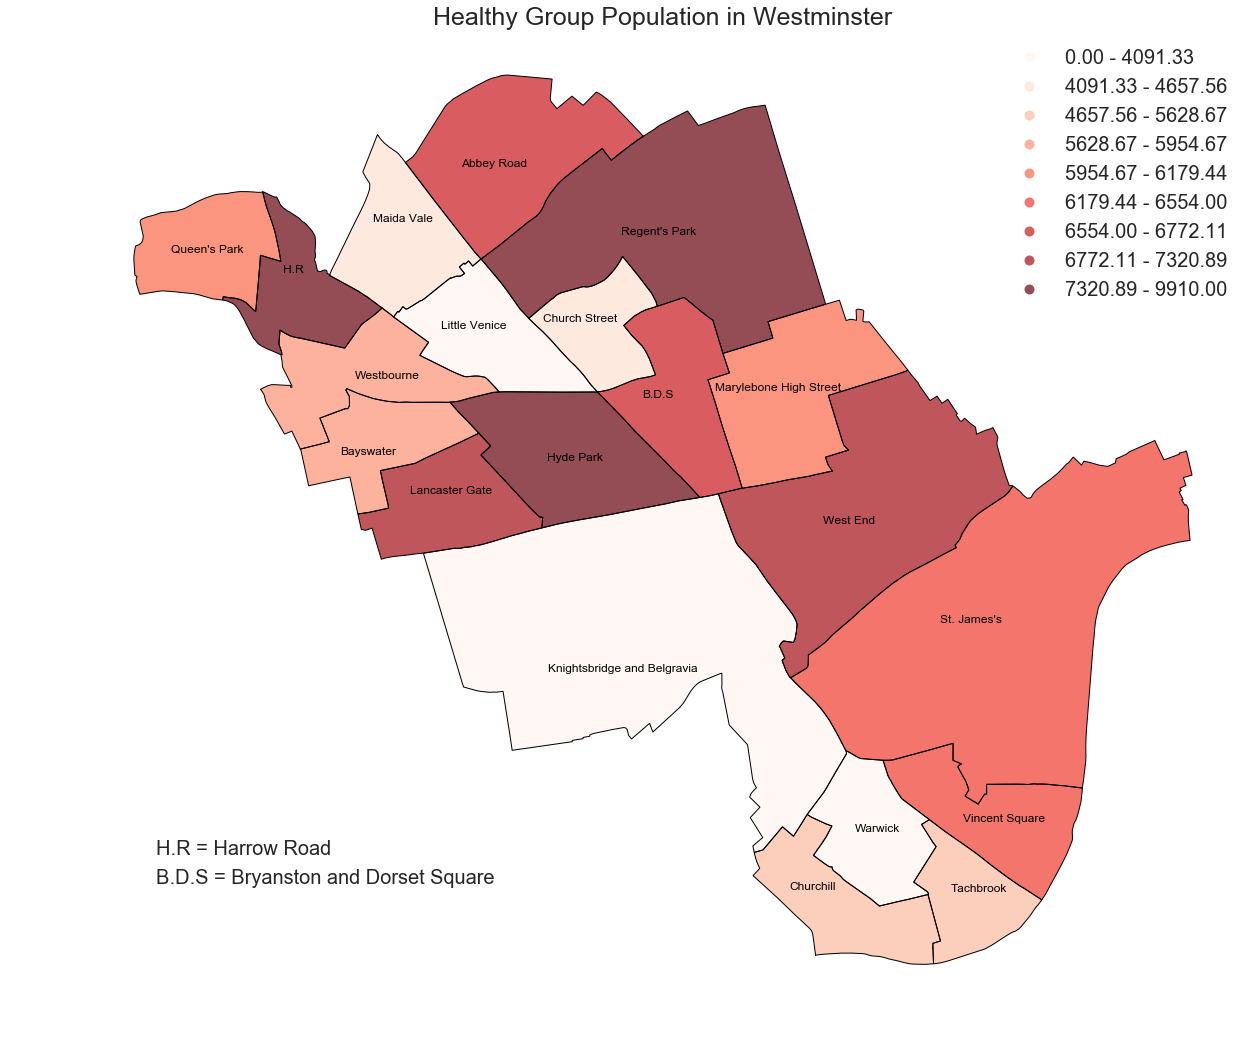

In [31]:
#plotting map of healthy group
#setting font scale to increase the legend size as they appeared tiny
sns.set(font_scale=2)
#plotting dataframe of healthy group using Quantiles which gives a good approximation of where population count
#falls within each ward
healthy_base = healthy_merged.plot(figsize = (20,15), column = 'TotalPopulation',
                         scheme = 'Quantiles', cmap=plt.cm.Reds, legend = True , k = 9, alpha=0.7 )

plt.title('Healthy Group Population in Westminster', fontsize=25)
#annotating the name of the abbreviated name
plt.annotate('B.D.S = Bryanston and Dorset Square', xy=(524000, 178300), fontsize=20)
plt.annotate('H.R = Harrow Road', xy=(524000, 178500), fontsize=20)
plt.axis('off')
plt.tight_layout()
#creating new columns to store coordinate points to pick up name of each ward to label map
healthy_merged['coords'] = healthy_merged['geometry'].apply(lambda x: x.representative_point().coords[:])
healthy_merged['coords'] = [coords[0] for coords in healthy_merged['coords']]

for idx, row in healthy_merged.iterrows():
    plt.annotate(s=row['NAME'], xy=row['coords'],horizontalalignment='center',color="Black",fontsize=12)
#saving figure    
plt.savefig('/Users/jamessolomon/Desktop/plots/healthy.png')

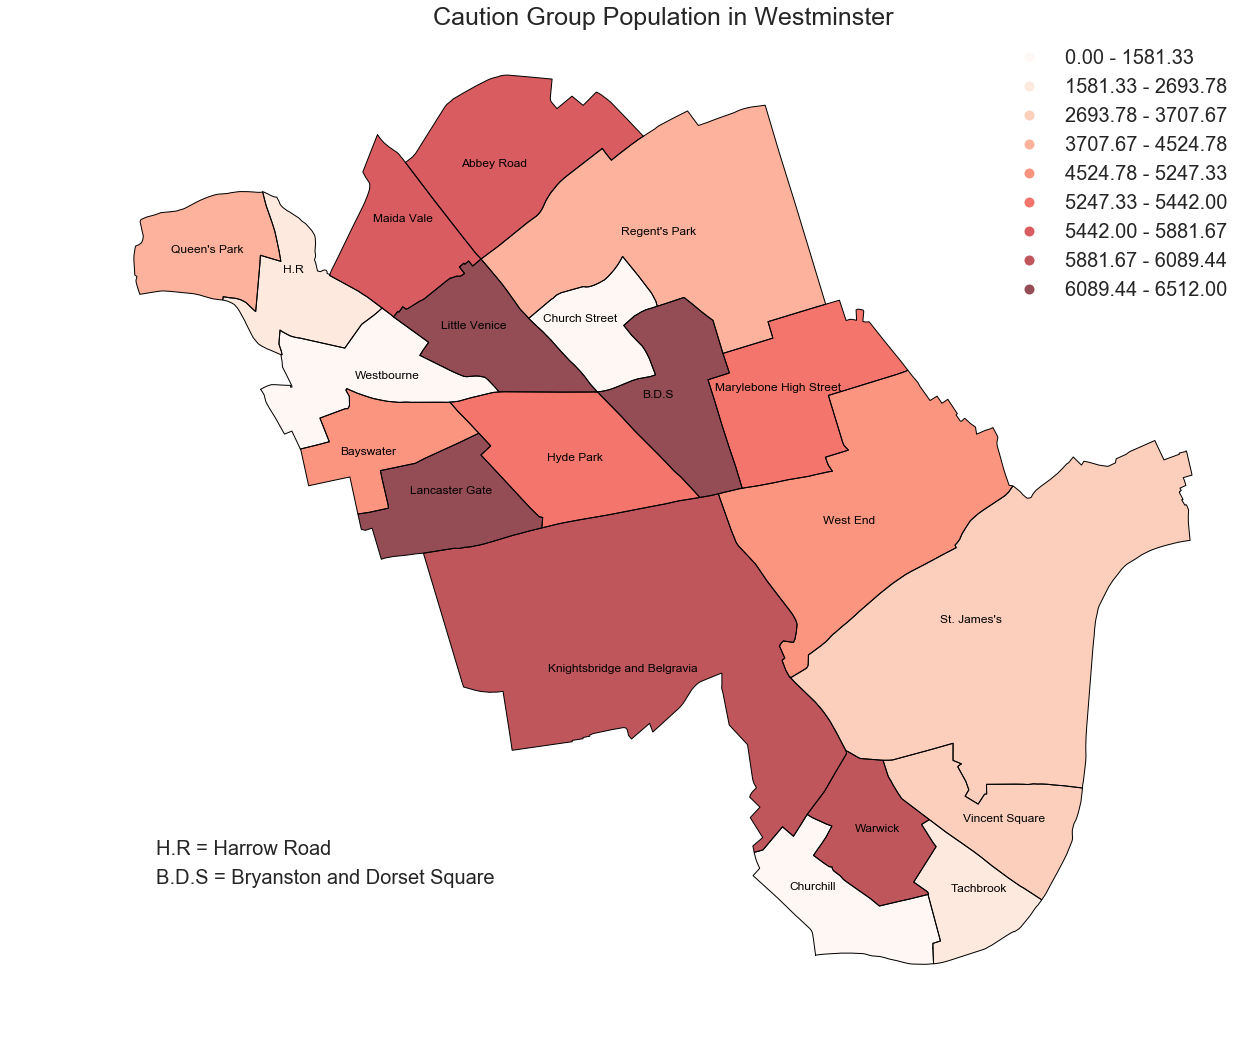

In [32]:
#plotting map of caution group
#setting font scale to increase the legend size as they appeared tiny
sns.set(font_scale=2)
#plotting dataframe of caution group using Quantiles which gives a good approximation of where population count
#falls within each ward
base = caution_merged.plot(figsize = (20,15), column = 'TotalPopulation',
                         scheme = 'Quantiles', cmap=plt.cm.Reds, legend = True , k = 9, alpha=0.7 )

plt.title('Caution Group Population in Westminster', fontsize=25)
#annotating the name of the abbreviated name
plt.annotate('B.D.S = Bryanston and Dorset Square', xy=(524000, 178300), fontsize=20)
plt.annotate('H.R = Harrow Road', xy=(524000, 178500), fontsize=20)
plt.axis('off')
plt.tight_layout()
#creating new columns to store coordinate points to pick up name of each ward to label map
caution_merged['coords'] = caution_merged['geometry'].apply(lambda x: x.representative_point().coords[:])
caution_merged['coords'] = [coords[0] for coords in caution_merged['coords']]

for idx, row in caution_merged.iterrows():
    plt.annotate(s=row['NAME'], xy=row['coords'],horizontalalignment='center',color="Black",fontsize=12)
#saving figure    
plt.savefig('/Users/jamessolomon/Desktop/plots/caution.png')

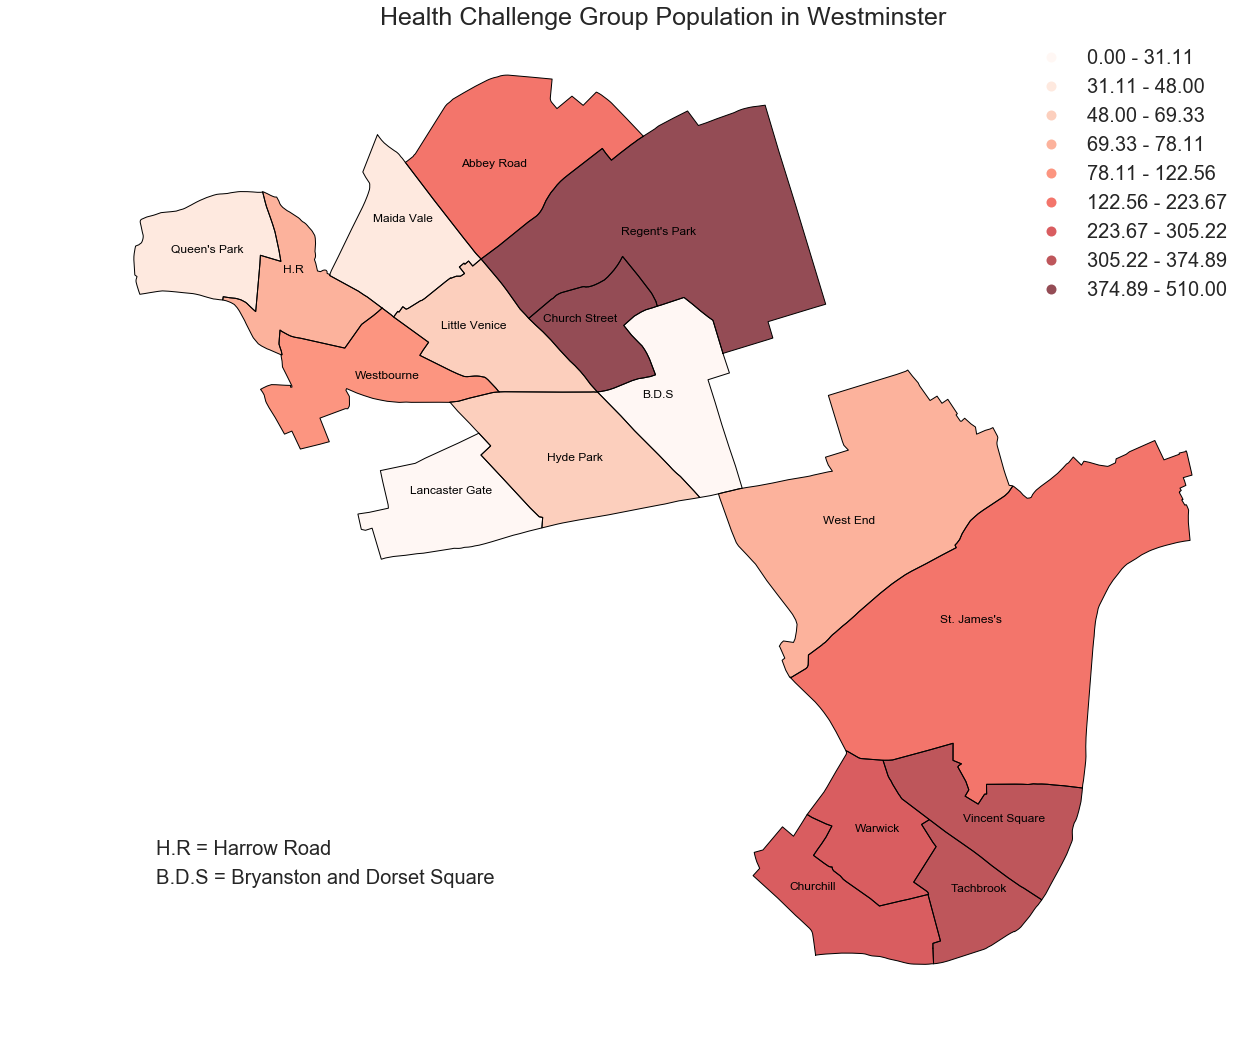

In [33]:
#plotting map of health challenge group
#setting font scale to increase the legend size as they appeared tiny
sns.set(font_scale=2)
#plotting dataframe of health challenge group using Quantiles which gives a good approximation of where population count
#falls within each ward
base = h_chlng_merged.plot(figsize = (20,15), column = 'TotalPopulation',
                         scheme = 'Quantiles', cmap=plt.cm.Reds, legend = True , k = 9, alpha=0.7 )

plt.title('Health Challenge Group Population in Westminster', fontsize=25)
#annotating the name of the abbreviated name
plt.annotate('B.D.S = Bryanston and Dorset Square', xy=(524000, 178300), fontsize=20)
plt.annotate('H.R = Harrow Road', xy=(524000, 178500), fontsize=20)
plt.axis('off')
plt.tight_layout()
#creating new columns to store coordinate points to pick up name of each ward to label map
h_chlng_merged['coords'] = h_chlng_merged['geometry'].apply(lambda x: x.representative_point().coords[:])
h_chlng_merged['coords'] = [coords[0] for coords in h_chlng_merged['coords']]

for idx, row in h_chlng_merged.iterrows():
    plt.annotate(s=row['NAME'], xy=row['coords'],horizontalalignment='center',color="Black",fontsize=12)
#saving figure      
plt.savefig('/Users/jamessolomon/Desktop/plots/health_challenge.png')

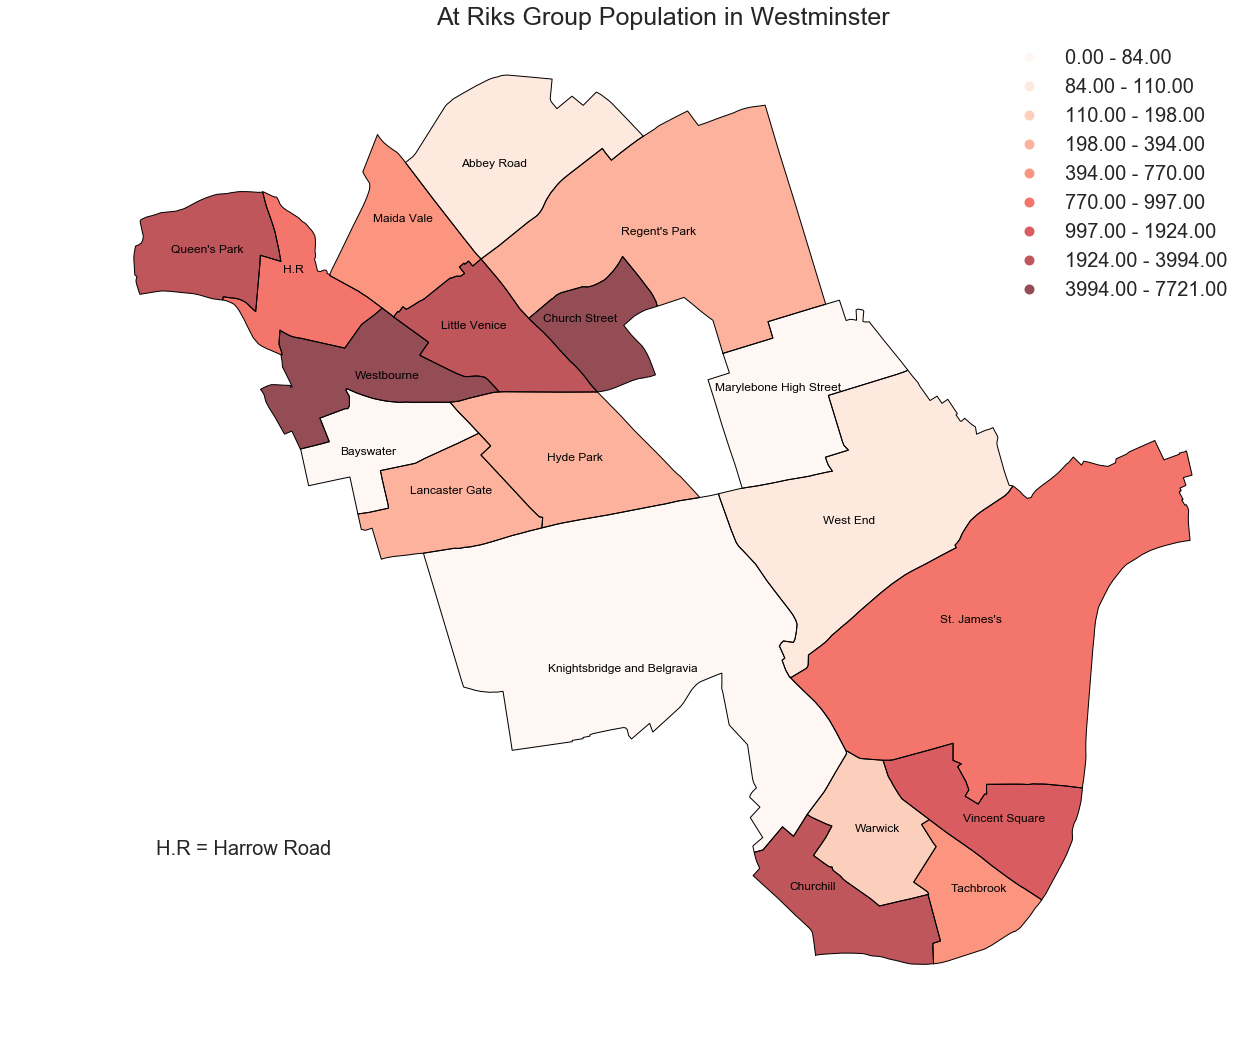

In [34]:
#plotting map of at risk group
#setting font scale to increase the legend size as they appeared tiny
sns.set(font_scale=2)
#plotting dataframe of at risk group using Quantiles which gives a good approximation of where population count
#falls within each ward
base = at_risk_merged.plot(figsize = (20,15), column = 'TotalPopulation',
                         scheme = 'Quantiles', cmap=plt.cm.Reds, legend = True , k = 9, alpha=0.7 )

plt.title('At Riks Group Population in Westminster', fontsize=25)
#annotating the name of the abbreviated name
plt.annotate('H.R = Harrow Road', xy=(524000, 178500), fontsize=20)
plt.axis('off')
plt.tight_layout()
#creating new columns to store coordinate points to pick up name of each ward to label map
at_risk_merged['coords'] = at_risk_merged['geometry'].apply(lambda x: x.representative_point().coords[:])
at_risk_merged['coords'] = [coords[0] for coords in at_risk_merged['coords']]

for idx, row in at_risk_merged.iterrows():
    plt.annotate(s=row['NAME'], xy=row['coords'],horizontalalignment='center',color="Black",fontsize=12)
#saving figure      
plt.savefig('/Users/jamessolomon/Desktop/plots/at_risk.png')

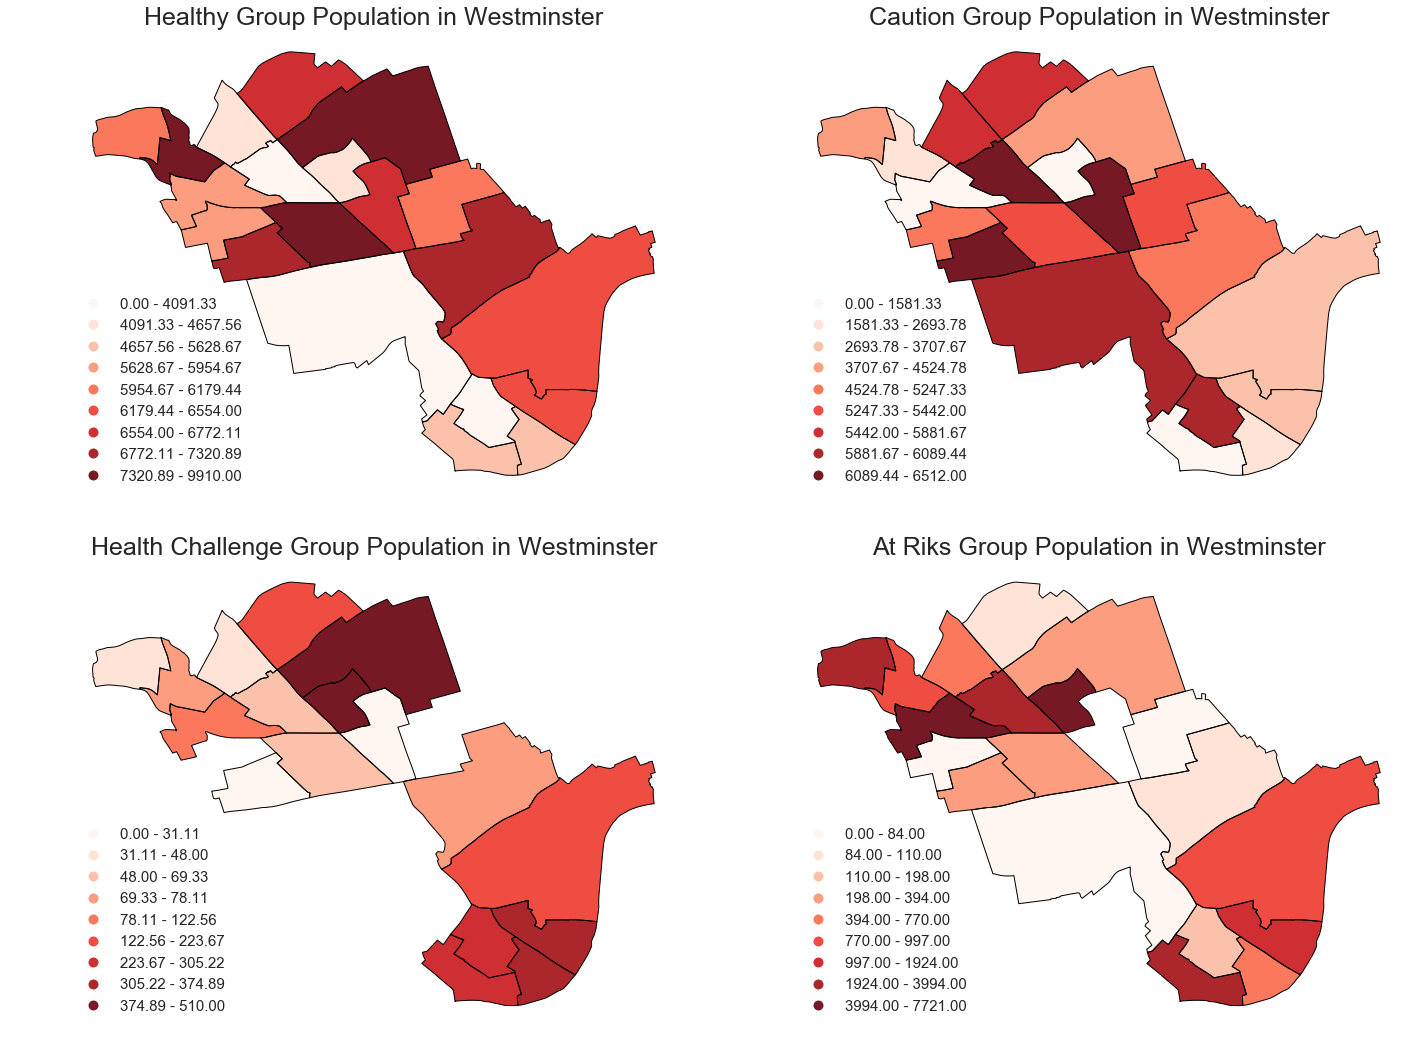

In [35]:
#sub-plotting map of wellbeinggroups
#setting font scale to increase the legend size as they appeared tiny, and creating a subplot call
sns.set(font_scale=1.5)
fig, ax = plt.subplots(nrows=2,ncols=2,figsize = (20,15))
#plotting dataframes of all groups using Quantiles which gives a good approximation of where population count
#falls within each ward
healthy_merged.plot(ax=ax[0][0] , column = 'TotalPopulation',
                         scheme = 'Quantiles', cmap=plt.cm.Reds, legend = True , k = 9, alpha=0.9 )
caution_merged.plot(ax=ax[0][1], column = 'TotalPopulation',
                         scheme = 'Quantiles', cmap=plt.cm.Reds, legend = True , k = 9, alpha=0.9 )
h_chlng_merged.plot(ax=ax[1][0], column = 'TotalPopulation',
                         scheme = 'Quantiles', cmap=plt.cm.Reds, legend = True , k = 9, alpha=0.9 )
at_risk_merged.plot(ax=ax[1][1], column = 'TotalPopulation',
                         scheme = 'Quantiles', cmap=plt.cm.Reds, legend = True , k = 9, alpha=0.9 )

ax[0][0].set_title('Healthy Group Population in Westminster', fontsize=25)
ax[0][1].set_title('Caution Group Population in Westminster', fontsize=25)
ax[1][0].set_title('Health Challenge Group Population in Westminster', fontsize=25)
ax[1][1].set_title('At Riks Group Population in Westminster', fontsize=25)

ax[0][0].axis('off')
ax[0][1].axis('off')
ax[1][0].axis('off')
ax[1][1].axis('off')

plt.tight_layout()
#saving figure
plt.savefig('/Users/jamessolomon/Desktop/plots/well-being-groups.png')

# SECTION C

This section plots a choropleth map of the category of residents in Westminster. It follows same steps used in section B
with the exception of the column attribute, Category, used to plot the areas on the map. 

In [49]:
#making a copy of the dataframe to keep the original intact
acorn_feat2 = acorn_feat.copy()

In [50]:
#creating new column to store geometry points of coordinates
acorn_feat2['geometry'] = [Point(xy) for xy in zip(acorn_feat2['Long'].astype('float'),acorn_feat2['Lat'].astype('float'))]

In [51]:
#dropping latitude and longitude columns as they are now contained in geometry column
acorn_feat2 = acorn_feat2.drop(['Long', 'Lat'], axis=1)

In [52]:
#assiging crs to coordinate points
acorn_point2 = gpd.GeoDataFrame(acorn_feat2,crs={'init' :'epsg:4326'})

In [53]:
#setting coordinate reference system of geodataframe as same as London ward dataframe
acorn_point2 = acorn_point2.to_crs(london.crs)

In [54]:
#spatial join of London ward dataframe and ACORN geodataframe
acorn_with_wards2 = gpd.sjoin(acorn_point2, london, how="inner", op='intersects')

In [55]:
#checking the contents of the dataframe
acorn_with_wards2.head(1)

Ward           Category                            CategoryType  \
0  Abbey Road  Rising Prosperity  Younger professionals in smaller flats   

  WellbeingGroup     WellbeingType  TotalPopulation  \
0        Healthy  Five-a-day greys               28   

                                      geometry  index_right      BOROUGH  \
0  POINT (525921.1326123769 183506.0971184813)          488  Westminster   

    GSS_CODE  HECTARES  LB_GSS_CD        NAME  NONLD_AREA  POLY_ID  
0  E05000630   109.492  E09000033  Abbey Road         0.0   117484

In [56]:
#creating dataframe to aggregate the population of each category for each ward
cat = pd.DataFrame(acorn_with_wards2.groupby(['Ward','Category'])['TotalPopulation'].sum())

In [57]:
#resetting index
cat = cat.reset_index()

In [132]:
#checking contents of dataframe
cat.head(2)

Ward                 Category  TotalPopulation
0  Abbey Road        Affluent Achiever             3677
1  Abbey Road  Comfortable Communities               50

In [59]:
#selecting affluent achievers as standalone dataframe
afl_ach = acorn_with_wards2[acorn_with_wards2.Category=='Affluent Achiever']

In [60]:
#aggregating population count for only affluent achievers for each ward
cat_afl_ach = pd.DataFrame(afl_ach[['Category','TotalPopulation','index_right']].groupby('index_right')['TotalPopulation'].sum())

In [61]:
#merging affluent achievers dataframe to London ward dataframe and replacing missing entries with zero
cat_afl_ach_mrg = london.merge(cat_afl_ach, left_index = True, right_index = True, how = 'inner').fillna(0).reset_index()

In [62]:
#renaming wards as it doesn't fit on map
#B.D.S for Bryanston and Dorset Square
#H.R for Harrow Road
cat_afl_ach_mrg['NAME'][7] = 'B.D.S'

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [63]:
#creating dataframe for only comfortable communities
cat_comf = acorn_with_wards2[acorn_with_wards2.Category=='Comfortable Communities']

In [64]:
#aggregating population of comfortable communities for each ward
cat_comf1 = pd.DataFrame(cat_comf[['Category','TotalPopulation','index_right']].groupby('index_right')['TotalPopulation'].sum())

In [65]:
#merging comfortable communities with London ward dataframe and replacing null enteries with zeros
cat_comf_mrg = london.merge(cat_comf1, left_index = True, right_index = True, how = 'inner').fillna(0).reset_index()

In [66]:
#creating dataframe for only financially stretched population
cat_stretched = acorn_with_wards2[acorn_with_wards2.Category=='Financially Stretched']

In [67]:
#aggregating financially stretched population count 
cat_stretched1 = pd.DataFrame(cat_stretched[['Category','TotalPopulation','index_right']].groupby('index_right')['TotalPopulation'].sum())

In [68]:
#merging London ward dataframe with financially stretched popuplation and replacing null enteries with zeros
cat_stretched_mrg = london.merge(cat_stretched1, left_index = True, right_index = True, how = 'inner').fillna(0).reset_index()

In [69]:
#Abbreviating wards as it does not fit on map
#B.D.S for Bryanston and Dorset Square
#H.R for Harrow Road
cat_stretched_mrg['NAME'][8] = 'B.D.S'
cat_stretched_mrg['NAME'][7] = 'H.R'

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [70]:
#creating dataframe for only not private households population count
cat_not_prvt = acorn_with_wards2[acorn_with_wards2.Category=='Not Private Households']

In [71]:
#aggregating not private household population count
cat_not_prvt1 = pd.DataFrame(cat_not_prvt[['Category','TotalPopulation','index_right']].groupby('index_right')['TotalPopulation'].sum())

In [72]:
#merging not private household population with London ward dataframe and replacing null enteries with zeros
cat_not_prvt_mrg = london.merge(cat_not_prvt1, left_index = True, right_index = True, how = 'inner').fillna(0).reset_index()

In [73]:
#Abbreviating wards as it does not fit on map
#B.D.S for Bryanston and Dorset Square
#H.R for Harrow Road
cat_not_prvt_mrg['NAME'][8] = 'B.D.S'
cat_not_prvt_mrg['NAME'][7] = 'H.R'

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [74]:
#selecting population with rising prosperity
cat_rising_pros = acorn_with_wards2[acorn_with_wards2.Category=='Rising Prosperity']

In [75]:
#aggregating rising prosperity population 
cat_rising_pros1 = pd.DataFrame(cat_rising_pros[['Category','TotalPopulation','index_right']].groupby('index_right')['TotalPopulation'].sum())

In [76]:
#merging London ward dataframe with rising prosperity dataframe and replacing null enteries with zeros
cat_rising_pros_mrg = london.merge(cat_rising_pros1, left_index = True, right_index = True, how = 'inner').fillna(0).reset_index()

In [77]:
#Abbreviating wards as it does not fit on map
#B.D.S for Bryanston and Dorset Square
#H.R for Harrow Road
cat_rising_pros_mrg['NAME'][8] = 'B.D.S'
cat_rising_pros_mrg['NAME'][7] = 'H.R'

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [78]:
#selecting urban adversity population 
cat_urban = acorn_with_wards2[acorn_with_wards2.Category=='Urban Adversity']

In [79]:
#aggregating population count of urban adversity
cat_urban1 = pd.DataFrame(cat_urban[['Category','TotalPopulation','index_right']].groupby('index_right')['TotalPopulation'].sum())

In [80]:
#merging London ward dataframe with urban adversity population
cat_urban_mrg = london.merge(cat_urban1, left_index = True, right_index = True, how = 'inner').fillna(0).reset_index()

In [81]:
#Abbreviating wards as it does not fit on map
#B.D.S for Bryanston and Dorset Square
#H.R for Harrow Road
cat_urban_mrg['NAME'][7] = 'B.D.S'
cat_urban_mrg['NAME'][6] = 'H.R'

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


# SECTION D

This section plots the choropleth map, following same steps as in section B.

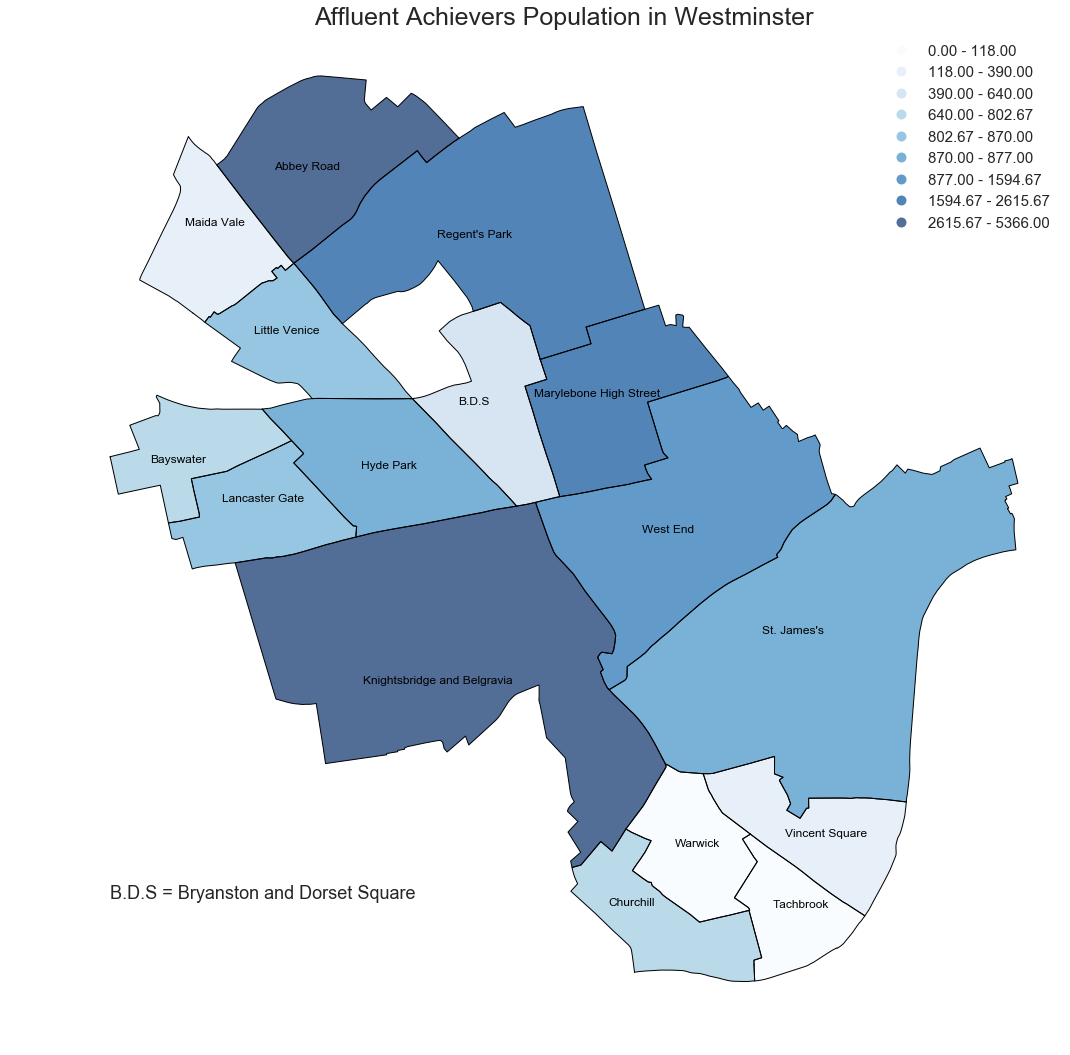

In [82]:
#plotting map of affluent achievers population
#setting font scale to increase the legend size as they appeared tiny
sns.set(font_scale=1.5)
#plotting dataframe of affluent achievers using Quantiles which gives a good approximation of where population count
#falls within each ward
base = cat_afl_ach_mrg.plot(figsize = (20,15), column = 'TotalPopulation',
                         scheme = 'Quantiles', cmap=plt.cm.Blues, legend = True , k = 9, alpha=0.7 )

plt.title('Affluent Achievers Population in Westminster', fontsize=25)
#annotating the name of the abbreviated name
plt.annotate('B.D.S = Bryanston and Dorset Square', xy=(525000, 178300))
plt.axis('off')
plt.tight_layout()
#creating new columns to store coordinate points to pick up name of each ward to label map
cat_afl_ach_mrg['coords'] = cat_afl_ach_mrg['geometry'].apply(lambda x: x.representative_point().coords[:])
cat_afl_ach_mrg['coords'] = [coords[0] for coords in cat_afl_ach_mrg['coords']]

for idx, row in cat_afl_ach_mrg.iterrows():
    plt.annotate(s=row['NAME'], xy=row['coords'],horizontalalignment='center',color="Black",fontsize=12)
#saving figure    
plt.savefig('/Users/jamessolomon/Desktop/plots/affluent.png')

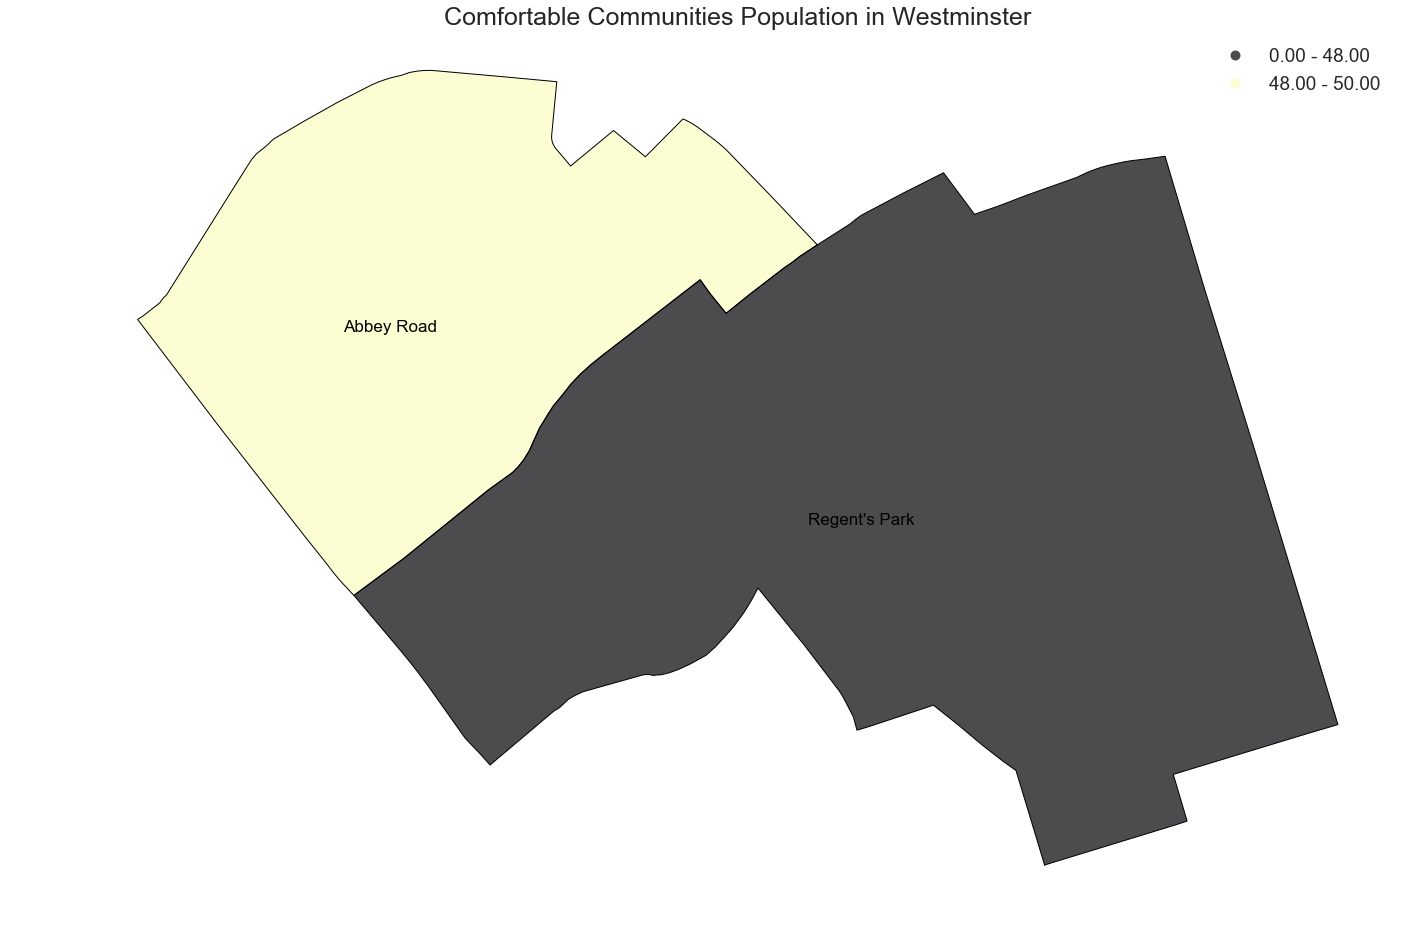

In [83]:
#plotting map of comfortable communities population 
#setting font scale to increase the legend size as they appeared tiny
sns.set(font_scale=1.9)
#plotting dataframe of comfortable communities using Quantiles which gives a good approximation of where population count
#falls within each ward
base = cat_comf_mrg.plot(figsize = (20,15), column = 'TotalPopulation',
                         scheme = 'Quantiles', cmap = 'magma', legend = True , k = 2, alpha=0.7 )

plt.title('Comfortable Communities Population in Westminster', fontsize=25)
plt.axis('off')
plt.tight_layout()
#creating new columns to store coordinate points to pick up name of each ward to label map
cat_comf_mrg['coords'] = cat_comf_mrg['geometry'].apply(lambda x: x.representative_point().coords[:])
cat_comf_mrg['coords'] = [coords[0] for coords in cat_comf_mrg['coords']]

for idx, row in cat_comf_mrg.iterrows():
    plt.annotate(s=row['NAME'], xy=row['coords'],horizontalalignment='center',color="Black",fontsize=17)
#saving figure      
plt.savefig('/Users/jamessolomon/Desktop/plots/comfortable.png')

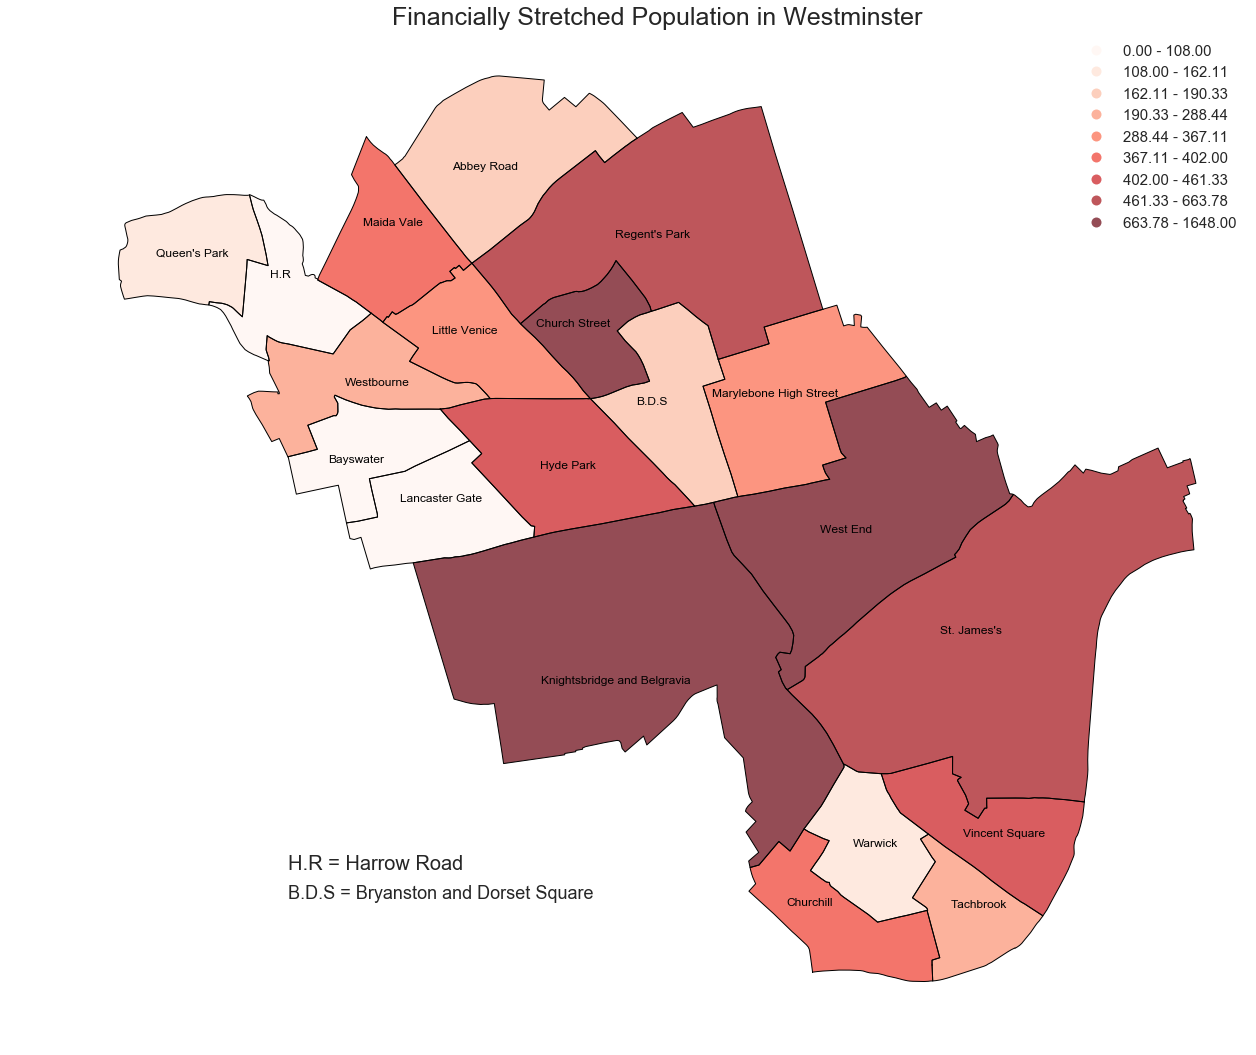

In [84]:
#plotting map of financially stretched population 
#setting font scale to increase the legend size as they appeared tiny
sns.set(font_scale=1.5)
base = cat_stretched_mrg.plot(figsize = (20,15), column = 'TotalPopulation',
                         scheme = 'Quantiles', cmap=plt.cm.Reds, legend = True , k = 9, alpha=0.7 )

plt.title('Financially Stretched Population in Westminster', fontsize=25)
#annotating the name of the abbreviated name
plt.annotate('B.D.S = Bryanston and Dorset Square', xy=(525000, 178300))
plt.annotate('H.R = Harrow Road', xy=(525000, 178500), fontsize=20)

plt.axis('off')
plt.tight_layout()
#creating new columns to store coordinate points to pick up name of each ward to label map
cat_stretched_mrg['coords'] = cat_stretched_mrg['geometry'].apply(lambda x: x.representative_point().coords[:])
cat_stretched_mrg['coords'] = [coords[0] for coords in cat_stretched_mrg['coords']]

for idx, row in cat_stretched_mrg.iterrows():
    plt.annotate(s=row['NAME'], xy=row['coords'],horizontalalignment='center',color="Black",fontsize=12)
#saving figure    
plt.savefig('/Users/jamessolomon/Desktop/plots/fin_stretched.png')

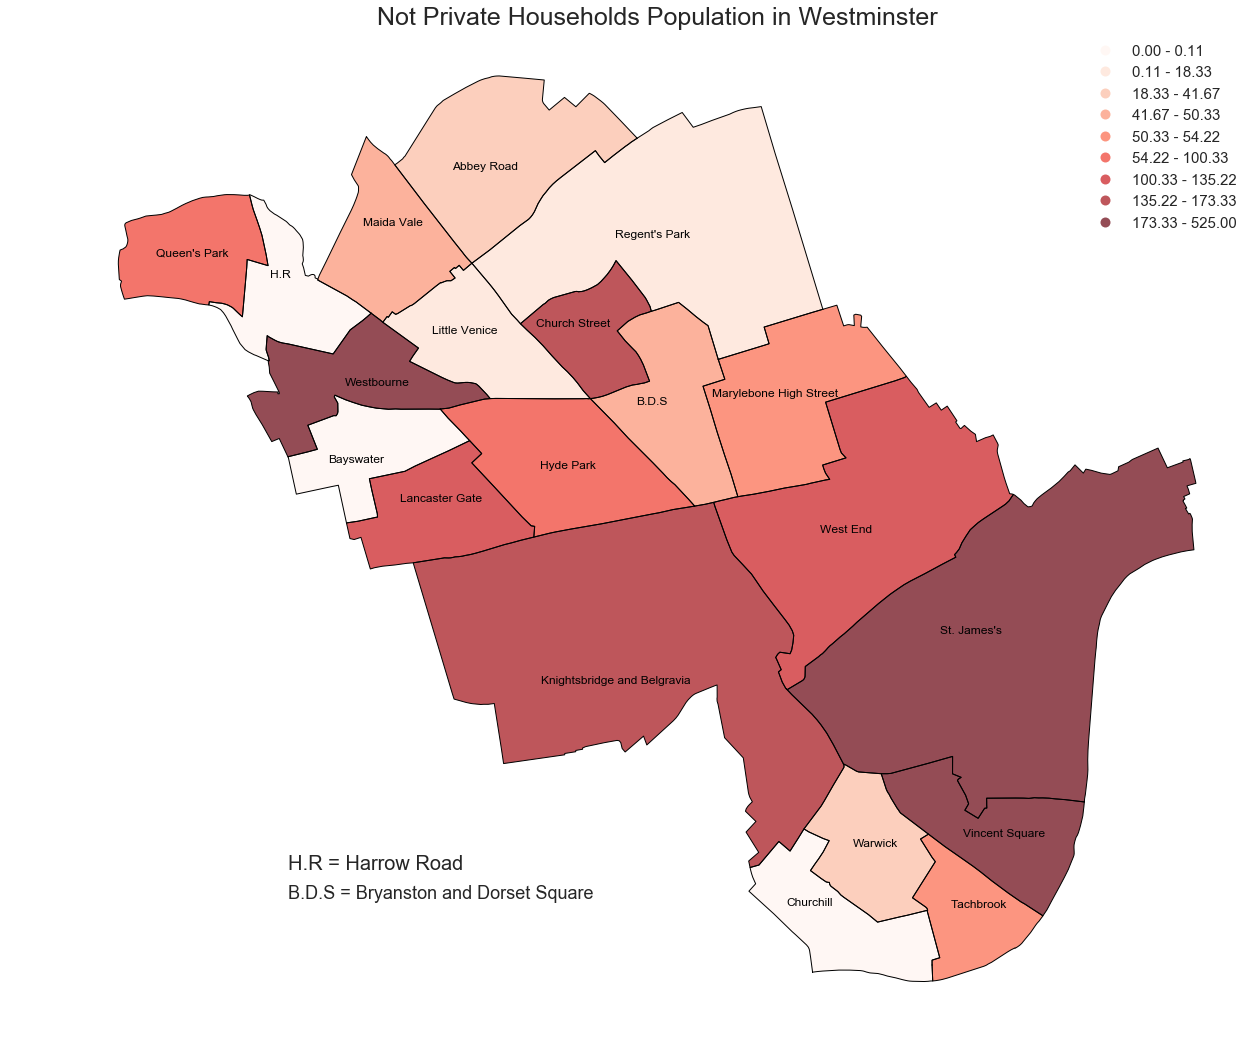

In [85]:
#plotting map of not private households population 
#setting font scale to increase the legend size as they appeared tiny
sns.set(font_scale=1.5)
#plotting dataframe of not private households using Quantiles which gives a good approximation of where population count
#falls within each ward
base = cat_not_prvt_mrg.plot(figsize = (20,15), column = 'TotalPopulation',
                         scheme = 'Quantiles', cmap=plt.cm.Reds, legend = True , k = 9, alpha=0.7 )

plt.title('Not Private Households Population in Westminster', fontsize=25)
#annotating the name of the abbreviated name
plt.annotate('B.D.S = Bryanston and Dorset Square', xy=(525000, 178300))
plt.annotate('H.R = Harrow Road', xy=(525000, 178500), fontsize=20)

plt.axis('off')
plt.tight_layout()
#creating new columns to store coordinate points to pick up name of each ward to label map
cat_not_prvt_mrg['coords'] = cat_not_prvt_mrg['geometry'].apply(lambda x: x.representative_point().coords[:])
cat_not_prvt_mrg['coords'] = [coords[0] for coords in cat_not_prvt_mrg['coords']]

for idx, row in cat_not_prvt_mrg.iterrows():
    plt.annotate(s=row['NAME'], xy=row['coords'],horizontalalignment='center',color="Black",fontsize=12)
#saving figure    
plt.savefig('/Users/jamessolomon/Desktop/plots/not_private.png')

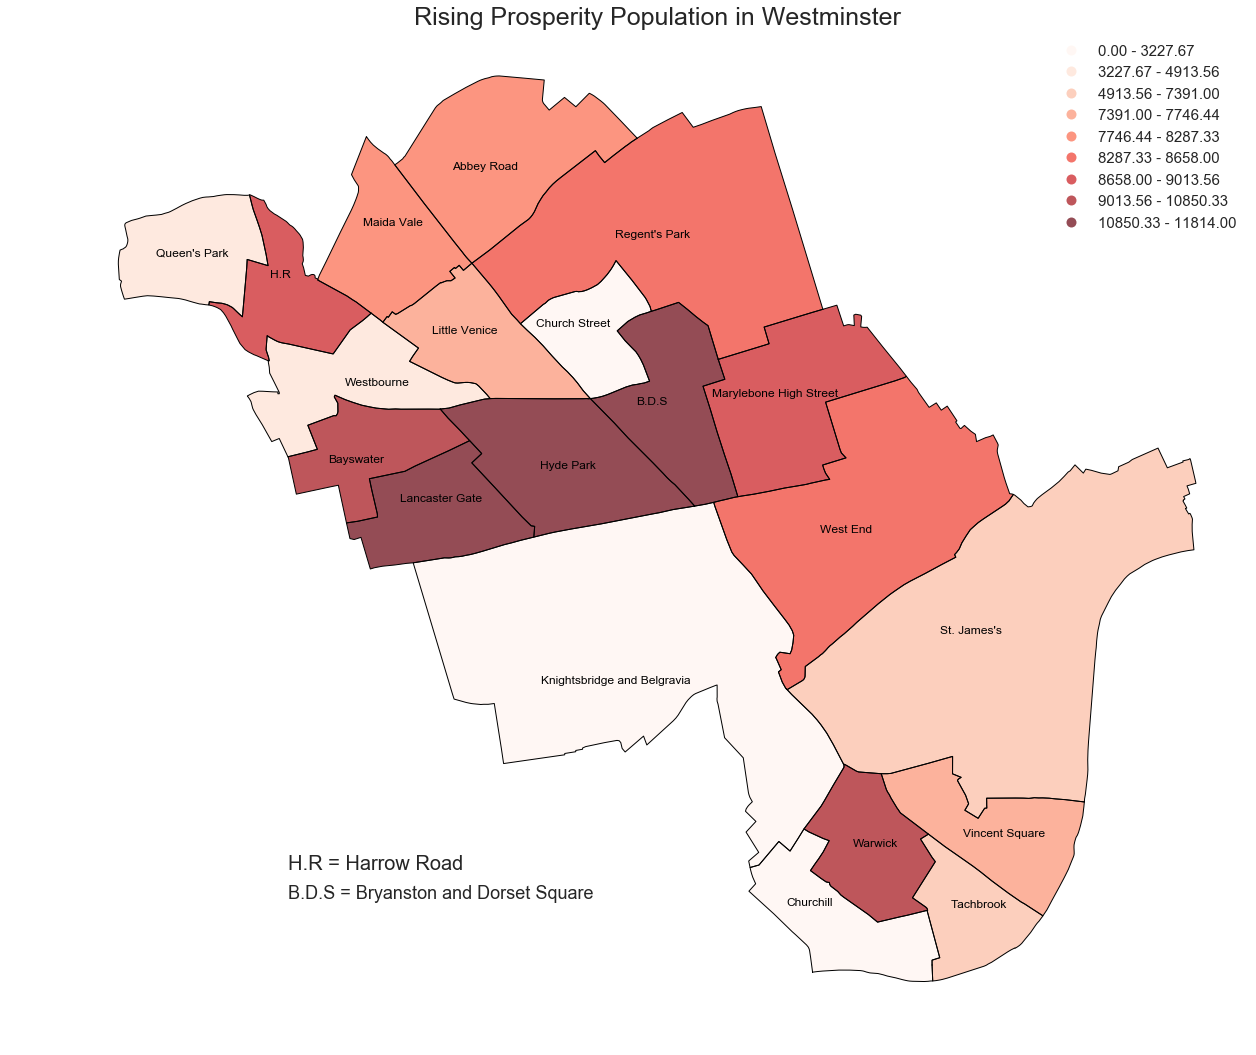

In [86]:
#plotting map of rising prosperity population 
#setting font scale to increase the legend size as they appeared tiny
sns.set(font_scale=1.5)
#plotting dataframe of rising prosperity using Quantiles which gives a good approximation of where population count
#falls within each ward
base = cat_rising_pros_mrg.plot(figsize = (20,15), column = 'TotalPopulation',
                         scheme = 'Quantiles', cmap=plt.cm.Reds, legend = True , k = 9, alpha=0.7 )

plt.title('Rising Prosperity Population in Westminster', fontsize=25)
#annotating the name of the abbreviated name
plt.annotate('B.D.S = Bryanston and Dorset Square', xy=(525000, 178300))
plt.annotate('H.R = Harrow Road', xy=(525000, 178500), fontsize=20)

plt.axis('off')
plt.tight_layout()
#creating new columns to store coordinate points to pick up name of each ward to label map
cat_rising_pros_mrg['coords'] = cat_rising_pros_mrg['geometry'].apply(lambda x: x.representative_point().coords[:])
cat_rising_pros_mrg['coords'] = [coords[0] for coords in cat_rising_pros_mrg['coords']]

for idx, row in cat_rising_pros_mrg.iterrows():
    plt.annotate(s=row['NAME'], xy=row['coords'],horizontalalignment='center',color="Black",fontsize=12)
#saving figure    
plt.savefig('/Users/jamessolomon/Desktop/plots/rising.png')

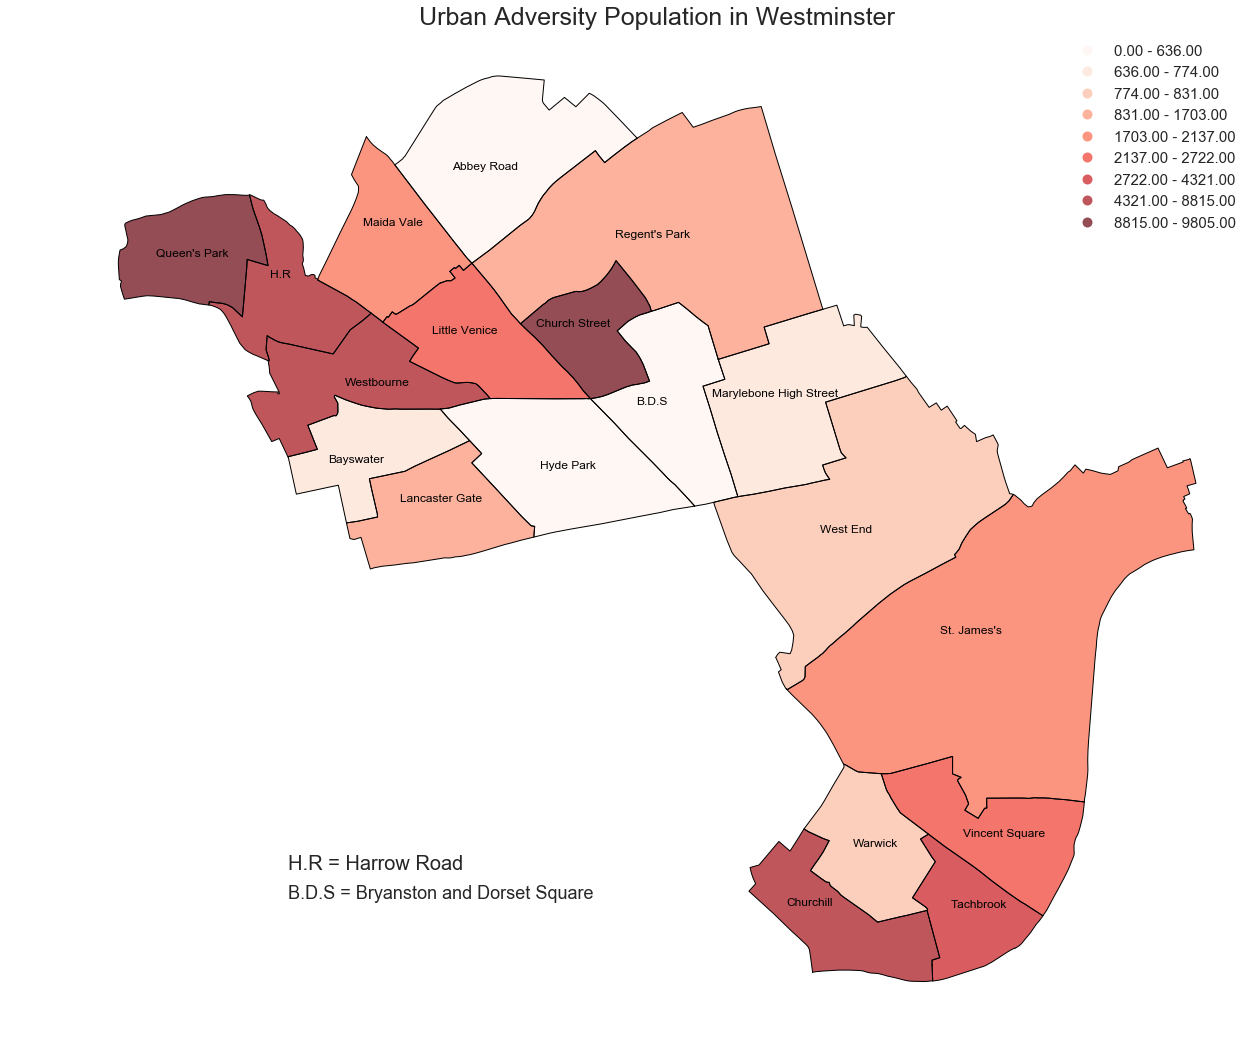

In [87]:
#plotting map of urban adversity population 
#setting font scale to increase the legend size as they appeared tiny
sns.set(font_scale=1.5)
#plotting dataframe of urban adversity using Quantiles which gives a good approximation of where population count
#falls within each ward
base = cat_urban_mrg.plot(figsize = (20,15), column = 'TotalPopulation',
                         scheme = 'Quantiles', cmap=plt.cm.Reds, legend = True , k = 9, alpha=0.7 )

plt.title('Urban Adversity Population in Westminster', fontsize=25)
#annotating the name of the abbreviated name
plt.annotate('B.D.S = Bryanston and Dorset Square', xy=(525000, 178300))
plt.annotate('H.R = Harrow Road', xy=(525000, 178500), fontsize=20)

plt.axis('off')
plt.tight_layout()
#creating new columns to store coordinate points to pick up name of each ward to label map
cat_urban_mrg['coords'] = cat_urban_mrg['geometry'].apply(lambda x: x.representative_point().coords[:])
cat_urban_mrg['coords'] = [coords[0] for coords in cat_urban_mrg['coords']]

for idx, row in cat_urban_mrg.iterrows():
    plt.annotate(s=row['NAME'], xy=row['coords'],horizontalalignment='center',color="Black",fontsize=12)
#saving figure    
plt.savefig('/Users/jamessolomon/Desktop/plots/adversity.png')

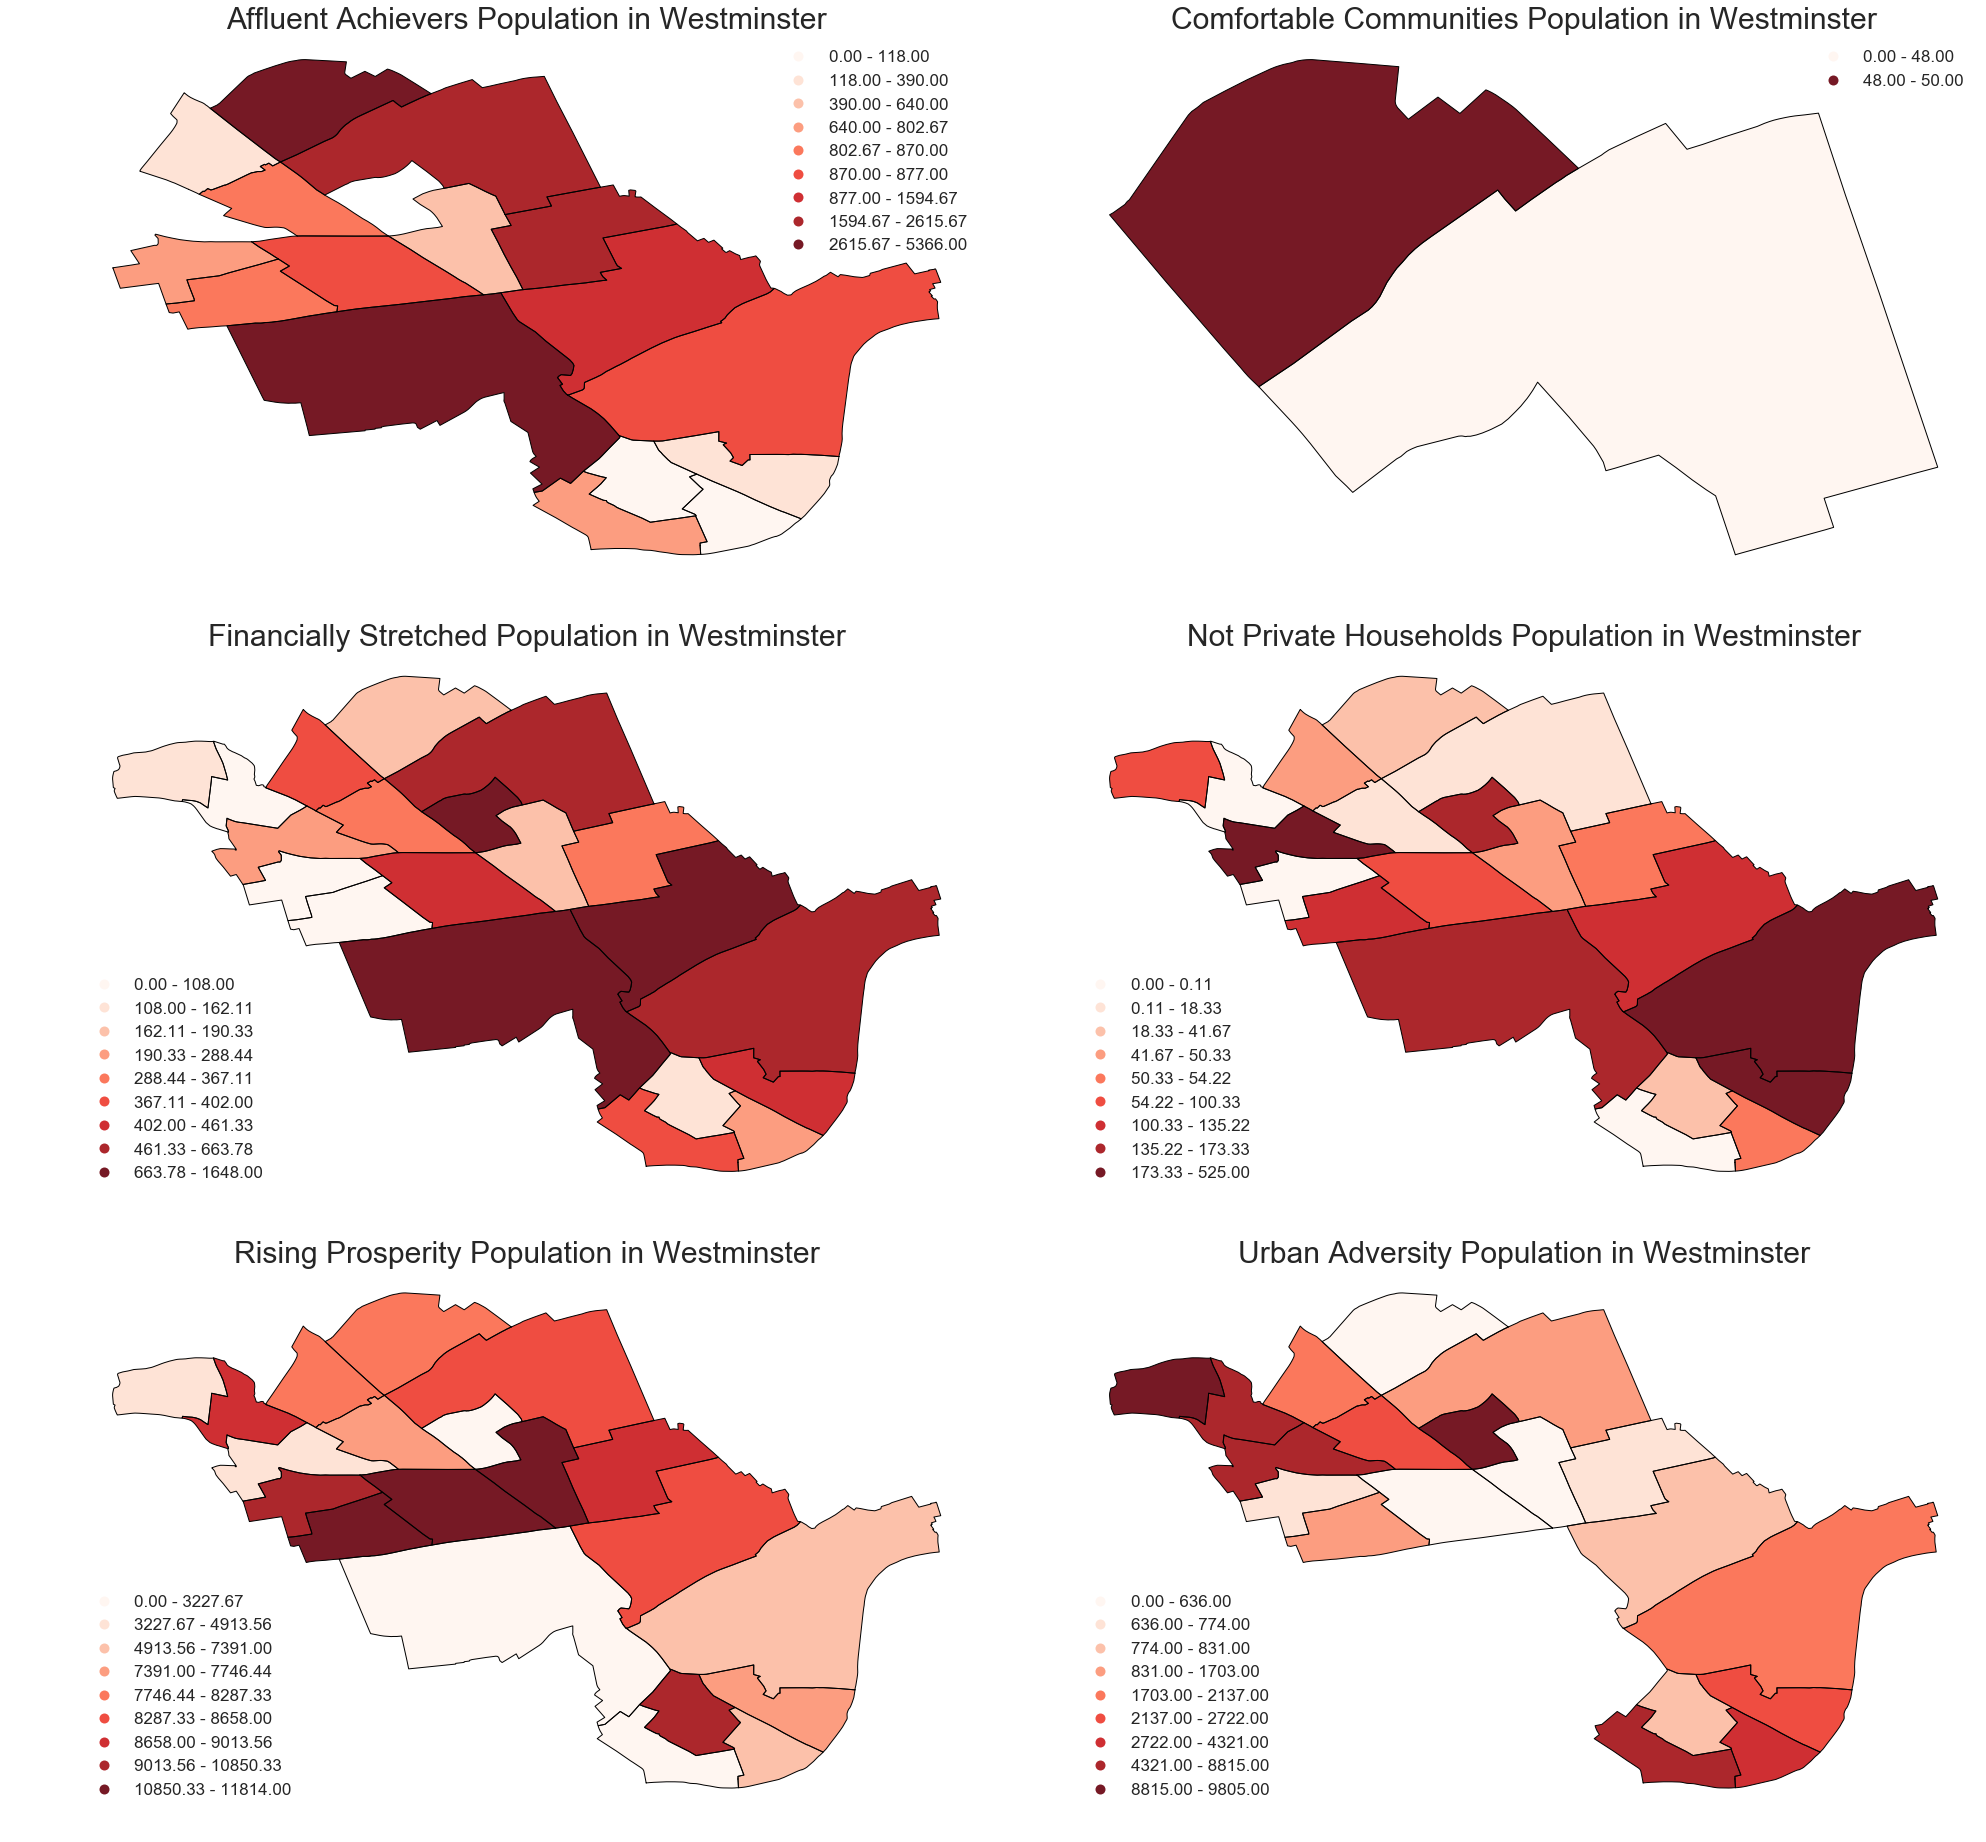

In [133]:
#sub-plotting map of category of residents
#setting font scale to increase the legend size as they appeared tiny, and creating a subplot call  
sns.set(font_scale=1.7)
fig, ax = plt.subplots(nrows=3, ncols=2,figsize = (28,26))
#plotting dataframes of all category types using Quantiles which gives a good approximation of where population count
#falls within each ward
cat_afl_ach_mrg.plot(ax=ax[0][0] , column = 'TotalPopulation',
                         scheme = 'Quantiles', cmap=plt.cm.Reds, legend = True , k = 9, alpha=0.9 )
cat_comf_mrg.plot(ax=ax[0][1], column = 'TotalPopulation',
                         scheme = 'Quantiles', cmap=plt.cm.Reds, legend = True , k = 2, alpha=0.9 )
cat_stretched_mrg.plot(ax=ax[1][0], column = 'TotalPopulation',
                         scheme = 'Quantiles', cmap=plt.cm.Reds, legend = True , k = 9, alpha=0.9 )
cat_not_prvt_mrg.plot(ax=ax[1][1], column = 'TotalPopulation',
                         scheme = 'Quantiles', cmap=plt.cm.Reds, legend = True , k = 9, alpha=0.9 )
cat_rising_pros_mrg.plot(ax=ax[2][0], column = 'TotalPopulation',
                        scheme = 'Quantiles', cmap=plt.cm.Reds, legend = True , k = 9, alpha=0.9 )
cat_urban_mrg.plot(ax=ax[2][1], column = 'TotalPopulation',
                         scheme = 'Quantiles', cmap=plt.cm.Reds, legend = True , k = 9, alpha=0.9 )

ax[0][0].set_title('Affluent Achievers Population in Westminster', fontsize=30)
ax[0][1].set_title('Comfortable Communities Population in Westminster', fontsize=30)
ax[1][0].set_title('Financially Stretched Population in Westminster', fontsize=30)
ax[1][1].set_title('Not Private Households Population in Westminster', fontsize=30)
ax[2][0].set_title('Rising Prosperity Population in Westminster', fontsize=30)
ax[2][1].set_title('Urban Adversity Population in Westminster', fontsize=30)

ax[0][0].axis('off')
ax[0][1].axis('off')
ax[1][0].axis('off')
ax[1][1].axis('off')
ax[2][0].axis('off')
ax[2][1].axis('off')

plt.tight_layout()
#saving figure
plt.savefig('/Users/jamessolomon/Desktop/plots/acorn_category2.png')

In [89]:
#complete wards is a customised dataframe of the shapefile I created using the Westminster wards shapefile and 
#ward labels matching each polygon from merged dataframe of the healthy group in the ACORN dataframe. Complete wards
#dataframe is read from the Licence notebook file
%store -r complete_wards

# SECTION E

The plot below is an overlay map of geometry points from the ACORN dataset on Westminster map created using the complete
wards shapefile dataframe. The ACORN dataset used is the spatial joined dataframe. This dataframe shares the same CRS
with the complete wards dataframe. This enables properly laying on of points on the map. 

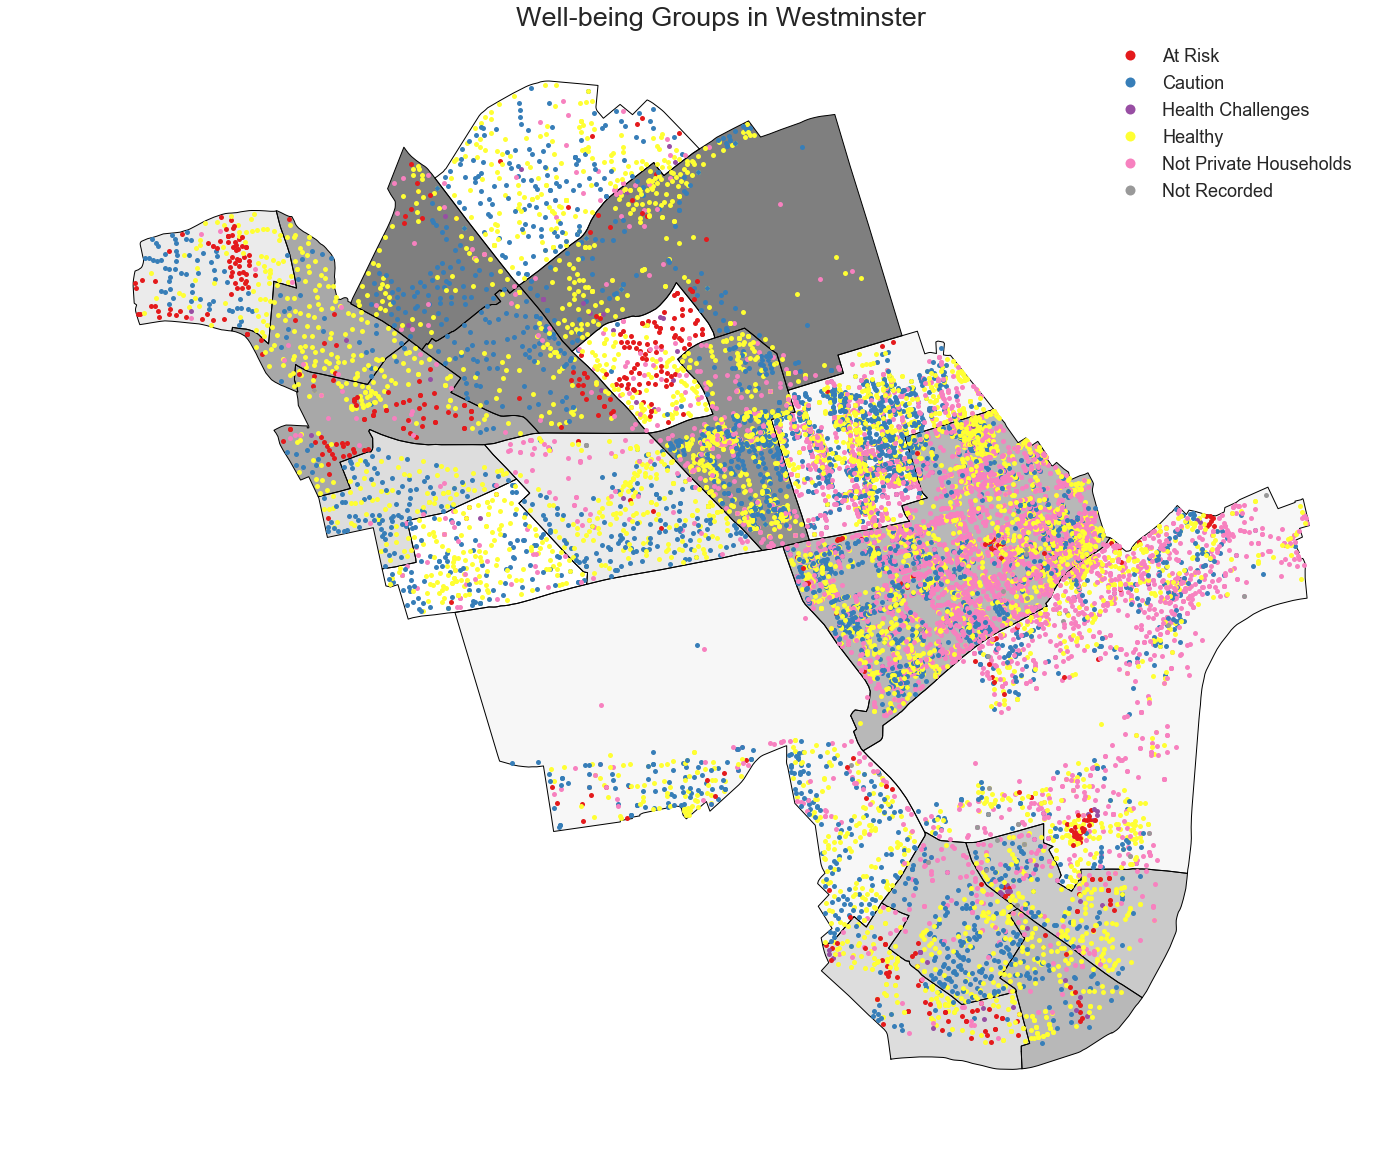

In [128]:
#plotting well-being groups in Westminster to show how dense an area is with respect to the wellbeinggroup
sns.set(font_scale=1.8)
base = complete_wards.plot(figsize=(30,20))
plt.title('Well-being Groups in Westminster', fontsize=27)
acorn_with_wards.plot(ax=base, marker='o', cmap='Set1',column='WellbeingGroup', markersize=5,legend=True,alpha=1)
plt.axis('off')
plt.savefig('/Users/jamessolomon/Desktop/plots/Well-being_group.png')

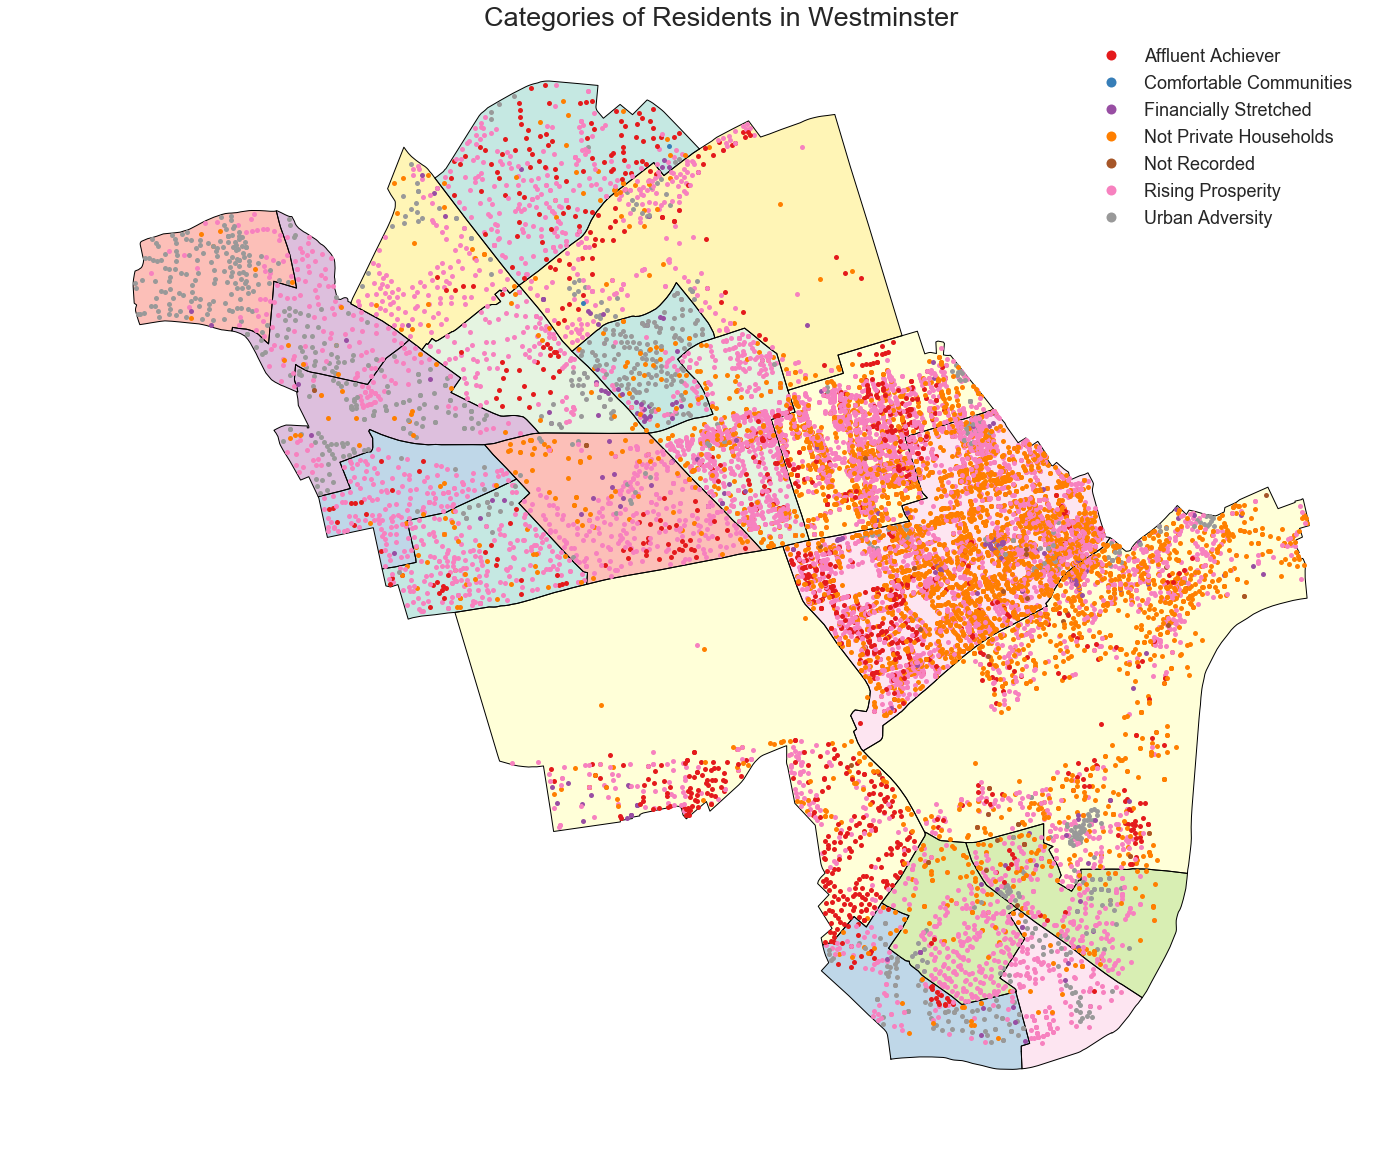

In [129]:
#plotting ACORN categories in Westminster to show how dense an area is with respect to the categories
sns.set(font_scale=1.8)
base = complete_wards.plot(figsize=(30,20),cmap='Set3')
plt.title('Categories of Residents in Westminster', fontsize=27)
acorn_with_wards.plot(ax=base, marker='o', cmap='Set1',column='Category', markersize=5,legend=True,alpha=1)
plt.axis('off')
plt.savefig('/Users/jamessolomon/Desktop/plots/Category2.png')

# SECTION F

I created this section to aggregate the population count for both wellbeinggroups and category of residents in 
Westminster in order to create a dataframe for statistical analysis in R.

In [96]:
#healthy group dataframe
healthy_gp3 = pd.DataFrame(healthy[['WellbeingGroup' , 'Ward',
                         'TotalPopulation']].groupby("Ward")['TotalPopulation'].sum())

In [97]:
#renaming column
healthy_gp3 = healthy_gp3.rename(columns={'TotalPopulation':'Healthy'})

In [99]:
#caution group dataframe
caution_gp3 = pd.DataFrame(caution[['WellbeingGroup' , 'Ward',
                         'TotalPopulation']].groupby("Ward")['TotalPopulation'].sum())

In [100]:
#renaming column
caution_gp3 = caution_gp3.rename(columns={'TotalPopulation':'Caution'})

In [102]:
#health challenges group dataframe
h_chlng_gp3 = pd.DataFrame(h_chlng[['WellbeingGroup' , 'Ward',
                         'TotalPopulation']].groupby("Ward")['TotalPopulation'].sum())

In [103]:
#renaming column
h_chlng_gp3 = h_chlng_gp3.rename(columns={'TotalPopulation':'Health_Challenge'})

In [105]:
#at risk group dataframe
at_risk_gp3 = pd.DataFrame(at_risk[['WellbeingGroup' , 'Ward',
                         'TotalPopulation']].groupby("Ward")['TotalPopulation'].sum())

In [106]:
#renaming column
at_risk_gp3 = at_risk_gp3.rename(columns={'TotalPopulation':'At_risk'})

In [114]:
#creating dataframes for all categories
cat_afl_grp = pd.DataFrame(afl_ach[['Category','TotalPopulation','Ward']].groupby('Ward')['TotalPopulation'].sum())
cat_comf1_grp = pd.DataFrame(cat_comf[['Category','TotalPopulation','Ward']].groupby('Ward')['TotalPopulation'].sum())
cat_stretched1_grp = pd.DataFrame(cat_stretched[['Category','TotalPopulation','Ward']].groupby('Ward')['TotalPopulation'].sum())
cat_not_prvt1_grp = pd.DataFrame(cat_not_prvt[['Category','TotalPopulation','Ward']].groupby('Ward')['TotalPopulation'].sum())
cat_rising_pros1_grp = pd.DataFrame(cat_rising_pros[['Category','TotalPopulation','Ward']].groupby('Ward')['TotalPopulation'].sum())
cat_urban1_grp = pd.DataFrame(cat_urban[['Category','TotalPopulation','Ward']].groupby('Ward')['TotalPopulation'].sum())

In [117]:
#renaming columns for all categories dataframes
cat_afl_grp = cat_afl_grp.rename(columns={'TotalPopulation':'Affluent_Achiever'})
cat_comf1_grp = cat_comf1_grp.rename(columns={'TotalPopulation':'Comfortable'})
cat_stretched1_grp = cat_stretched1_grp.rename(columns={'TotalPopulation':'Financially_Stretched'})
cat_not_prvt1_grp = cat_not_prvt1_grp.rename(columns={'TotalPopulation':'Not_Private_House'})
cat_rising_pros1_grp = cat_rising_pros1_grp.rename(columns={'TotalPopulation':'Rising_Prosperity'})
cat_urban1_grp = cat_urban1_grp.rename(columns={'TotalPopulation':'Urban_adversity'})

In [118]:
#joining all dataframes created above
grps = pd.concat([healthy_gp3,caution_gp3,at_risk_gp3,h_chlng_gp3,cat_afl_grp,cat_comf1_grp,
                 cat_stretched1_grp,cat_not_prvt1_grp,cat_rising_pros1_grp,cat_urban1_grp],axis=1)

In [119]:
#filling all null enteries with zeros
grps = grps.fillna(0)

In [123]:
#checking contents
grps.head(2)

Healthy  Caution  At_risk  Health_Challenge  Affluent Achiever  \
Abbey Road     6700     5487     95.0             127.0             3677.0   
Bayswater      5876     5119     16.0               0.0              746.0   

            Comfortable  Financially_Stretched  Not_Private_House  \
Abbey Road         50.0                    189                 38   
Bayswater           0.0                     44                  0   

            Rising_Prosperity  Urban_adversity  
Abbey Road               8087            406.0  
Bayswater                9541            680.0

In [124]:
#storing dataframe to use in dataframe for all notebook file
%store grps

Stored 'grps' (DataFrame)
